$$ ITI \space AI-Pro: \space Intake \space 45 $$
$$ Deep \space Learning $$
$$ Lab \space no. \space 2 $$

# Introduction

> Use the `keras` from Tensorflow to build ANN model that would fit the credit score data and be able to generalize well.

Use the Credit Score Classification dataset provided [here](https://www.kaggle.com/datasets/parisrohan/credit-score-classification) to train and test your design.

**Notes:**
- Split the data as you see fit and use validation during training.
- You may re-use the EDA, data preparation, and other sections you previously used in ML1 assignemnts.
- Remember that you can use classification metrics from other libraries as well (e.g., `sklearn`)
- Plot the loss, and accuracy against epochs and extract insights on how well of a fit your model is.
- This time the notebook is not prepared with sections and instructions so that you can do it yourself.
- If you are stuck, you can consult the [Keras User Guide](https://keras.io/api/). There are some useful [Code Examples](https://keras.io/examples/) as well.


In [1]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer,SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler,RobustScaler
from keras.callbacks import EarlyStopping
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense
from keras import Input
from keras.utils import set_random_seed
from tensorflow.keras.utils import to_categorical

In [2]:
train = pd.read_csv('/content/train.csv')

<ipython-input-2-e7bab7bf7086>:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('/content/train.csv')


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

In [4]:
cols_to_convert = ['Age', 'Annual_Income', 'Num_of_Loan', 'Changed_Credit_Limit', 'Outstanding_Debt', 'Monthly_Balance','Num_of_Delayed_Payment',"Amount_invested_monthly"]
for col in cols_to_convert:
    train[col] = pd.to_numeric(train[col], errors='coerce')

In [5]:
def convert_to_months(text):
    match = re.match(r"(\d+) Years? and (\d+) Months?", str(text))
    if match:
        years = int(match.group(1))
        months = int(match.group(2))
        return years * 12 + months
    return None

In [6]:
train["Credit_History_Age"] = train["Credit_History_Age"].apply(convert_to_months)
train["Credit_History_Age"]

,Credit_History_Age
0,265.0
1,NaN
2,267.0
3,268.0
4,269.0
...,...
99995,378.0
99996,379.0
99997,380.0
99998,381.0


In [7]:
train["Payment_Behaviour"].replace("!@9#%8",np.nan, inplace=True)

<ipython-input-7-f582c5e3d95f>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train["Payment_Behaviour"].replace("!@9#%8",np.nan, inplace=True)


In [8]:
train['Occupation'].replace("_______", np.nan, inplace=True)

<ipython-input-8-ac2f9117a785>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Occupation'].replace("_______", np.nan, inplace=True)


In [9]:
train['Payment_of_Min_Amount'].replace("NM",np.nan,inplace=True)

<ipython-input-9-5941a56fba33>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Payment_of_Min_Amount'].replace("NM",np.nan,inplace=True)


In [10]:
train["Credit_Mix"]=train["Credit_Mix"].replace("_",np.nan)

In [11]:
train.drop(columns=["ID", "Customer_ID", "SSN","Type_of_Loan","Name"],inplace=True)

In [12]:
X=train.drop("Credit_Score",axis=1)
Y=train.Credit_Score

In [13]:
x_train,x_valid,y_train,y_valid=train_test_split(X,Y,test_size=0.15,random_state=123)

In [14]:
knn_imputer = KNNImputer(n_neighbors=5)
numerical_cols = x_train.select_dtypes(exclude=["object"]).columns
x_train[numerical_cols] = knn_imputer.fit_transform(x_train[numerical_cols])

In [15]:
mode_imputer = SimpleImputer(strategy="most_frequent")
categorical_cols = ["Credit_Mix", "Payment_of_Min_Amount","Occupation","Payment_Behaviour"]
x_train[categorical_cols] = mode_imputer.fit_transform(x_train[categorical_cols])

In [16]:
scaler = RobustScaler()
x_train[numerical_cols]= scaler.fit_transform(x_train[numerical_cols])
#scaling
x_valid[numerical_cols]= scaler.transform(x_valid[numerical_cols])

In [17]:
# Features to be ordinally encoded
ordinal_features = ['Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour']

# Features to be one-hot encoded
onehot_features = ['Occupation',"Month"]

In [18]:
# Define ordinal categories
credit_mix_order = ['Bad', 'Standard', 'Good']
payment_min_order = ['NM', 'Yes', 'No']
payment_behaviour_order = [
    'High_spent_Small_value_payments',
    'Low_spent_Small_value_payments',
    'Low_spent_Medium_value_payments',
    'High_spent_Medium_value_payments',
    'Low_spent_Large_value_payments',
    'High_spent_Large_value_payments',
    'Other'  # Added missing category
]

# Features to be ordinally and one-hot encoded
ordinal_features = ['Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour']
onehot_features = ['Occupation', "Month"]

# Initialize encoders
ordinal_encoder = OrdinalEncoder(categories=[credit_mix_order,
                                             payment_min_order,
                                             payment_behaviour_order])

onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Apply ordinal encoding
x_train_ordinal = ordinal_encoder.fit_transform(x_train[ordinal_features])
ordinal_df = pd.DataFrame(x_train_ordinal, columns=ordinal_features, index=x_train.index)

# Apply one-hot encoding
x_train_onehot = onehot_encoder.fit_transform(x_train[onehot_features])
onehot_columns = onehot_encoder.get_feature_names_out(onehot_features)
onehot_df = pd.DataFrame(x_train_onehot, columns=onehot_columns, index=x_train.index)

# Combine all features
x_train = x_train.drop(columns=ordinal_features + onehot_features)
x_train = pd.concat([x_train, ordinal_df, onehot_df], axis=1)

In [19]:
x_valid[numerical_cols] = knn_imputer.transform(x_valid[numerical_cols])

# Mode
x_valid[categorical_cols] = mode_imputer.transform(x_valid[categorical_cols])
x_valid_ordinal = ordinal_encoder.transform(x_valid[ordinal_features])
ordinal_df = pd.DataFrame(x_valid_ordinal, columns=ordinal_features, index=x_valid.index)

# Apply one-hot encoding
x_valid_onehot = onehot_encoder.transform(x_valid[onehot_features])
onehot_columns = onehot_encoder.get_feature_names_out(onehot_features)
onehot_df = pd.DataFrame(x_valid_onehot, columns=onehot_columns, index=x_valid.index)

# Combine all features
x_valid = x_valid.drop(columns=ordinal_features + onehot_features)
x_valid = pd.concat([x_valid, ordinal_df, onehot_df], axis=1)


In [20]:
y_train

,Credit_Score
67105,Good
78945,Poor
25231,Standard
55380,Poor
41975,Poor
...,...
63206,Standard
61404,Poor
17730,Standard
28030,Standard


In [21]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_valid_encoded = label_encoder.transform(y_valid)

# # Step 2: Convert integers to one-hot encoding
y_train_categorical = to_categorical(y_train_encoded)
y_valid_categorical = to_categorical(y_valid_encoded)



### Modeling

##### trial_1

In [22]:
model=Sequential()
model.add(Dense(128,activation="relu",input_shape=(x_train.shape[1],)))
model.add(Dense(64,activation="relu"))
model.add(Dense(32,activation="relu"))
model.add(Dense(3, activation='softmax'))
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           5,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,067 (62.76 KB)

 Trainable params: 16,067 (62.76 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
model.compile(keras.optimizers.Adam(0.001), loss="categorical_crossentropy", metrics=["accuracy", "Precision"])


In [24]:
history=model.fit(x_train, y_train_categorical, batch_size=32, epochs=15, validation_split=0.15)

Epoch 1/15
2258/2258 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - Precision: 0.6415 - accuracy: 0.6062 - loss: 1.0303 - val_Precision: 0.7150 - val_accuracy: 0.6525 - val_loss: 0.7521
Epoch 2/15
2258/2258 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - Precision: 0.7241 - accuracy: 0.6621 - loss: 0.7351 - val_Precision: 0.7122 - val_accuracy: 0.6587 - val_loss: 0.7442
Epoch 3/15
2258/2258 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - Precision: 0.7036 - accuracy: 0.6667 - loss: 0.7223 - val_Precision: 0.6989 - val_accuracy: 0.6651 - val_loss: 0.7309
Epoch 4/15
2258/2258 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - Precision: 0.7086 - accuracy: 0.6744 - loss: 0.7116 - val_Precision: 0.7028 - val_accuracy: 0.6675 - val_loss: 0.7199
Epoch 5/15
2258/2258 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - Precision: 0.7145 - accuracy: 0.6805 - loss: 0.7005 - val_Precision: 0.7078 - val_accuracy: 0.6712 - val_loss: 0.7163
Epoch 6/15
2258/2258 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - Precision: 0.7115 - accuracy: 0.6797 - loss: 0.6949 - val_Precision: 0.

In [25]:
model.evaluate(x_valid, y_valid_categorical)

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - Precision: 0.5768 - accuracy: 0.5679 - loss: 2.5758


[2.5596699714660645, 0.5703999996185303, 0.579189658164978]

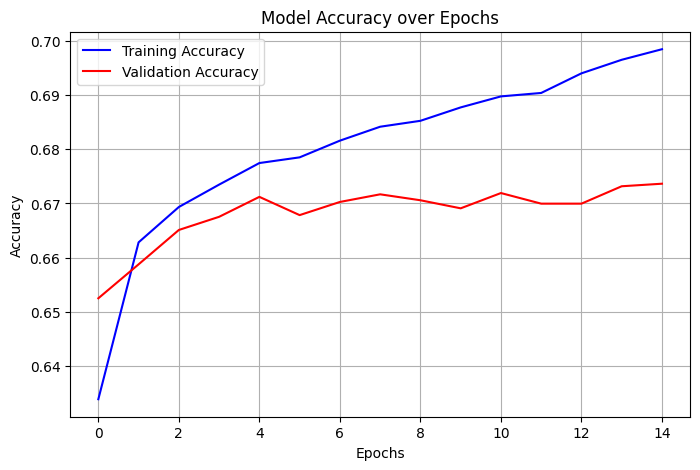

In [26]:
import matplotlib.pyplot as plt

# Extract accuracy and validation accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot accuracy curves
plt.figure(figsize=(8, 5))
plt.plot(train_acc, label='Training Accuracy', color='blue')
plt.plot(val_acc, label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy over Epochs')
plt.legend()
plt.grid()
plt.show()


### Trial_2

In [27]:
y_train_categorical = np.array(y_train_categorical)
y_valid_categorical = np.array(y_valid_categorical)

In [28]:
model2=Sequential()
model2.add(Dense(64,activation="relu",input_shape=(x_train.shape[1],)))
model2.add(Dense(32,activation="relu"))
model2.add(Dense(16,activation="relu"))
model2.add(Dense(3, activation='softmax'))
model2.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 64)                  │           2,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,475 (21.39 KB)

 Trainable params: 5,475 (21.39 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
model2.compile(keras.optimizers.Adam(0.00001), loss="categorical_crossentropy", metrics=["accuracy", "Precision"])


In [30]:
print("Original x shape:", x_train.shape)
print("Original y shape:", y_train_categorical.shape)

Original x shape: (85000, 43)
Original y shape: (85000, 3)


In [31]:
history2=model2.fit(x_train, y_train_categorical, batch_size=32, epochs=15, validation_data=(x_valid, y_valid_categorical))

Epoch 1/15
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - Precision: 0.4445 - accuracy: 0.3857 - loss: 1.9128 - val_Precision: 0.4728 - val_accuracy: 0.4751 - val_loss: 113.8977
Epoch 2/15
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - Precision: 0.5348 - accuracy: 0.5139 - loss: 1.1299 - val_Precision: 0.5336 - val_accuracy: 0.5259 - val_loss: 25.4711
Epoch 3/15
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - Precision: 0.5617 - accuracy: 0.5374 - loss: 1.0508 - val_Precision: 0.5447 - val_accuracy: 0.5326 - val_loss: 25.9769
Epoch 4/15
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - Precision: 0.5781 - accuracy: 0.5480 - loss: 1.0160 - val_Precision: 0.5528 - val_accuracy: 0.5401 - val_loss: 22.9574
Epoch 5/15
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - Precision: 0.5881 - accuracy: 0.5576 - loss: 0.9801 - val_Precision: 0.5576 - val_accuracy: 0.5457 - val_loss: 23.8725
Epoch 6/15
2657/2657 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - Precision: 0.5919 - accuracy: 0.5646 - loss: 0.9591 - val_Precis

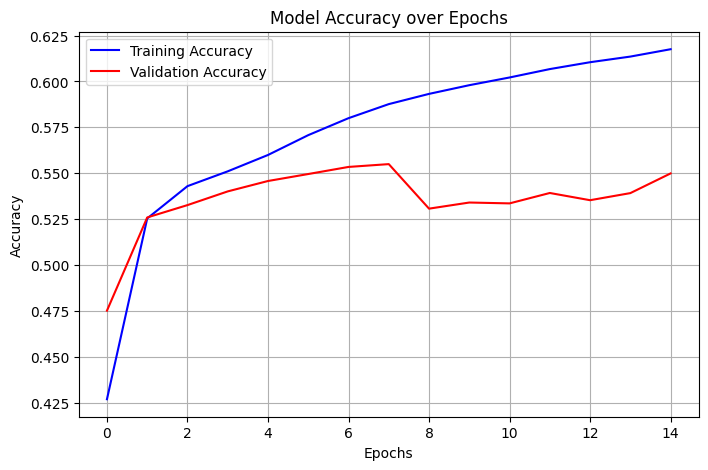

In [32]:
import matplotlib.pyplot as plt

# Extract accuracy and validation accuracy
train_acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

# Plot accuracy curves
plt.figure(figsize=(8, 5))
plt.plot(train_acc, label='Training Accuracy', color='blue')
plt.plot(val_acc, label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy over Epochs')
plt.legend()
plt.grid()
plt.show()


##### trial_3

In [33]:
model3=Sequential()
model3.add(Dense(128,activation="relu",input_shape=(x_train.shape[1],)))
model3.add(Dense(64,activation="relu"))
model3.add(Dense(32,activation="relu"))
model3.add(Dense(3, activation='softmax'))
model3.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 128)                 │           5,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,067 (62.76 KB)

 Trainable params: 16,067 (62.76 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
model3.compile(keras.optimizers.RMSprop(0.001), loss="categorical_crossentropy", metrics=["accuracy", "Precision"])


In [35]:
history3=model3.fit(x_train, y_train_categorical, batch_size=64, epochs=15, validation_split=0.15)

Epoch 1/15
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - Precision: 0.6180 - accuracy: 0.5875 - loss: 1.1169 - val_Precision: 0.6899 - val_accuracy: 0.6471 - val_loss: 0.7665
Epoch 2/15
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - Precision: 0.7055 - accuracy: 0.6551 - loss: 0.7487 - val_Precision: 0.7125 - val_accuracy: 0.6555 - val_loss: 0.7422
Epoch 3/15
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - Precision: 0.7156 - accuracy: 0.6678 - loss: 0.7274 - val_Precision: 0.7322 - val_accuracy: 0.6653 - val_loss: 0.7327
Epoch 4/15
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - Precision: 0.7201 - accuracy: 0.6721 - loss: 0.7164 - val_Precision: 0.7322 - val_accuracy: 0.6683 - val_loss: 0.7213
Epoch 5/15
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - Precision: 0.7254 - accuracy: 0.6777 - loss: 0.7043 - val_Precision: 0.7194 - val_accuracy: 0.6733 - val_loss: 0.7155
Epoch 6/15
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - Precision: 0.7229 - accuracy: 0.6784 - loss: 0.7031 - val_Precision: 0.709

In [36]:
model3.evaluate(x_valid, y_valid_categorical)

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - Precision: 0.5598 - accuracy: 0.5521 - loss: 43.6990


[43.65151596069336, 0.5527333617210388, 0.5585657358169556]

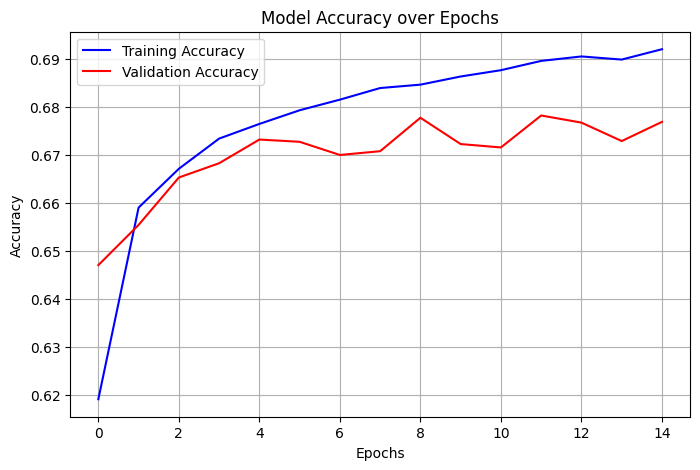

In [37]:
import matplotlib.pyplot as plt

# Extract accuracy and validation accuracy
train_acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

# Plot accuracy curves
plt.figure(figsize=(8, 5))
plt.plot(train_acc, label='Training Accuracy', color='blue')
plt.plot(val_acc, label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy over Epochs')
plt.legend()
plt.grid()
plt.show()


#### trial_4 is the best  So

In [38]:
model=Sequential()
model.add(Dense(128,activation="relu",input_shape=(x_train.shape[1],)))
model.add(Dense(64,activation="relu"))
model.add(Dense(32,activation="relu"))
model.add(Dense(16,activation="relu"))
model.add(Dense(8,activation="relu"))
model.add(Dense(3, activation='softmax'))
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                     │ (None, 128)                 │           5,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 3)                   │              27 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,659 (65.07 KB)

 Trainable params: 16,659 (65.07 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
model.compile(keras.optimizers.Adam(0.0001), loss="categorical_crossentropy", metrics=["accuracy", "Precision"])


In [40]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

In [41]:
history4=model.fit(x_train, y_train_categorical, batch_size=32, epochs=100, validation_split=0.15,callbacks=[early_stop])

Epoch 1/100
2258/2258 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - Precision: 0.5599 - accuracy: 0.5603 - loss: 1.0389 - val_Precision: 0.6715 - val_accuracy: 0.6252 - val_loss: 0.8169
Epoch 2/100
2258/2258 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - Precision: 0.6803 - accuracy: 0.6334 - loss: 0.8053 - val_Precision: 0.6988 - val_accuracy: 0.6427 - val_loss: 0.7811
Epoch 3/100
2258/2258 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - Precision: 0.7053 - accuracy: 0.6466 - loss: 0.7720 - val_Precision: 0.7034 - val_accuracy: 0.6471 - val_loss: 0.7653
Epoch 4/100
2258/2258 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - Precision: 0.7146 - accuracy: 0.6548 - loss: 0.7496 - val_Precision: 0.7113 - val_accuracy: 0.6544 - val_loss: 0.7556
Epoch 5/100
2258/2258 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - Precision: 0.7208 - accuracy: 0.6617 - loss: 0.7401 - val_Precision: 0.7049 - val_accuracy: 0.6565 - val_loss: 0.7475
Epoch 6/100
2258/2258 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - Precision: 0.7226 - accuracy: 0.6630 - loss: 0.7325 - val_Precision

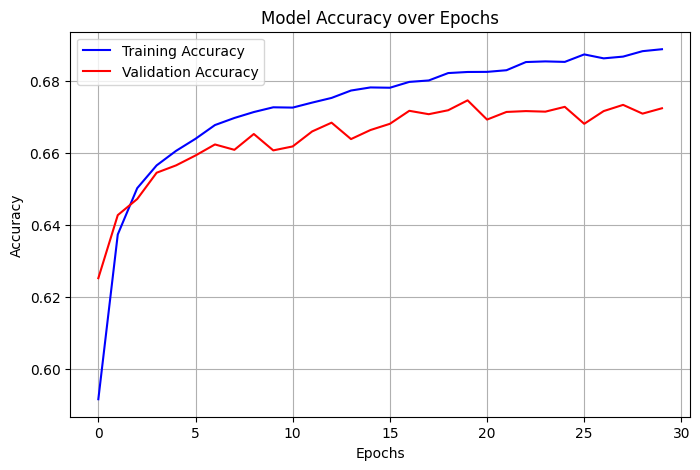

In [42]:
import matplotlib.pyplot as plt

# Extract accuracy and validation accuracy
train_acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']

# Plot accuracy curves
plt.figure(figsize=(8, 5))
plt.plot(train_acc, label='Training Accuracy', color='blue')
plt.plot(val_acc, label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy over Epochs')
plt.legend()
plt.grid()
plt.show()


### Trial_5

In [43]:
model5=Sequential()
model5.add(Dense(64,activation="relu",input_shape=(x_train.shape[1],)))
model5.add(Dense(64,activation="relu"))
model5.add(Dense(16,activation="relu"))
model5.add(Dense(8,activation="relu"))
model5.add(Dense(3, activation='softmax'))
model5.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                     │ (None, 64)                  │           2,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 3)                   │              27 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,179 (31.95 KB)

 Trainable params: 8,179 (31.95 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
model5.compile(keras.optimizers.Adam(0.0001), loss="categorical_crossentropy", metrics=["accuracy", "Precision"])


In [45]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)

In [46]:
history5=model5.fit(x_train, y_train_categorical, batch_size=64, epochs=100, validation_split=0.15,callbacks=[early_stop])

Epoch 1/100
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - Precision: 0.3268 - accuracy: 0.4149 - loss: 1.3058 - val_Precision: 0.5391 - val_accuracy: 0.5947 - val_loss: 0.9603
Epoch 2/100
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - Precision: 0.5691 - accuracy: 0.5992 - loss: 0.9334 - val_Precision: 0.6108 - val_accuracy: 0.6002 - val_loss: 0.8796
Epoch 3/100
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - Precision: 0.6156 - accuracy: 0.6050 - loss: 0.8703 - val_Precision: 0.6148 - val_accuracy: 0.6010 - val_loss: 0.8449
Epoch 4/100
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - Precision: 0.6305 - accuracy: 0.6079 - loss: 0.8359 - val_Precision: 0.6658 - val_accuracy: 0.6202 - val_loss: 0.8182
Epoch 5/100
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - Precision: 0.6705 - accuracy: 0.6306 - loss: 0.8075 - val_Precision: 0.6683 - val_accuracy: 0.6384 - val_loss: 0.7953
Epoch 6/100
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - Precision: 0.6749 - accuracy: 0.6436 - loss: 0.7890 - val_Precision:

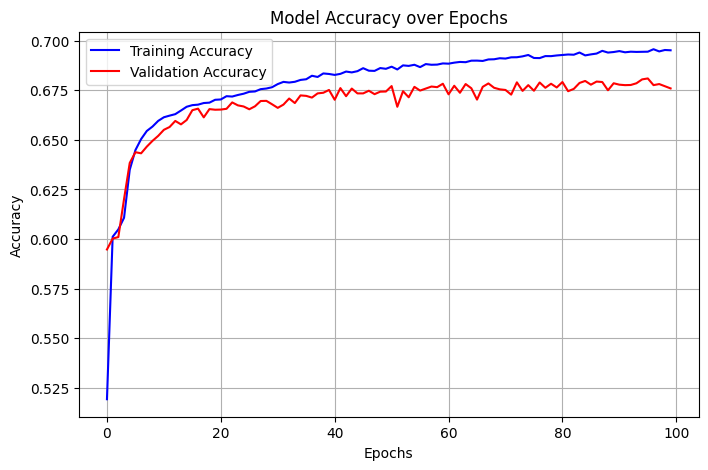

In [47]:
import matplotlib.pyplot as plt

# Extract accuracy and validation accuracy
train_acc = history5.history['accuracy']
val_acc = history5.history['val_accuracy']

# Plot accuracy curves
plt.figure(figsize=(8, 5))
plt.plot(train_acc, label='Training Accuracy', color='blue')
plt.plot(val_acc, label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy over Epochs')
plt.legend()
plt.grid()
plt.show()


----------------------------------------------

$$ Wish \space you \space all \space the \space best \space ♡ $$
$$ Abdelrahman \space Eid $$